QUESTION 2.1

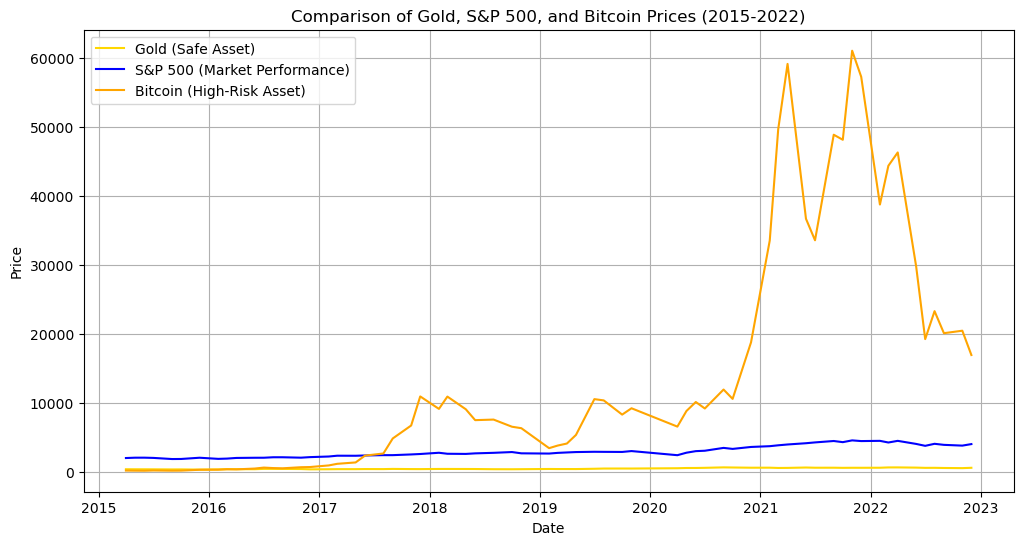

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred
import yfinance as yf

# Initialize FRED API
fred = Fred(api_key='37424f5f27244bc1352056c81cee6f76')

# Fetch Gold price data from FRED
gold_data = fred.get_series('ID7108', observation_start='2015-01-01', observation_end='2022-12-31')

# Fetch S&P 500 Index data from FRED
sp500_data = fred.get_series('SP500', observation_start='2015-01-01', observation_end='2022-12-31')

# Fetch Bitcoin price data using Yahoo Finance
btc = yf.Ticker("BTC-USD")
btc_data = btc.history(start="2015-01-01", end="2022-12-31")['Close']

# Ensure all time series are timezone-naive
gold_data.index = gold_data.index.tz_localize(None)
sp500_data.index = sp500_data.index.tz_localize(None)
btc_data.index = btc_data.index.tz_localize(None)

# Combine data into a single DataFrame
data = pd.DataFrame({
    'Gold': gold_data,
    'S&P 500': sp500_data,
    'Bitcoin': btc_data
})

# Drop rows with missing values
data.dropna(inplace=True)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Gold'], label='Gold (Safe Asset)', color='gold')
plt.plot(data.index, data['S&P 500'], label='S&P 500 (Market Performance)', color='blue')
plt.plot(data.index, data['Bitcoin'], label='Bitcoin (High-Risk Asset)', color='orange')
plt.title('Comparison of Gold, S&P 500, and Bitcoin Prices (2015-2022)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

QUESTION 2.2

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from fredapi import Fred

# Define your Fred API key
FRED_API_KEY = '37424f5f27244bc1352056c81cee6f76' # Replace with your actual Fred API key
fred = Fred(api_key=FRED_API_KEY)

# Define tickers and time period
tickers = {"gold": "GLD", "bitcoin": "BTC-USD", "sp500": "^GSPC"}
start_date = "2015-01-01"
end_date = "2020-12-31"

# Initialize an empty dictionary for storing data
data = {}

# Fetch data from Yahoo Finance
for name, ticker in tickers.items():
    print(f"Downloading data for {name} ({ticker})...")
    df = yf.download(ticker, start=start_date, end=end_date)
    if df.empty:
        print(f"No data found for {name} ({ticker}). Skipping...")
        continue
    # Use 'Adj Close' or fallback to 'Close'
    if 'Adj Close' in df.columns:
        data[name] = df['Adj Close']
    elif 'Close' in df.columns:
        data[name] = df['Close']
    else:
        print(f"No valid price column found for {name} ({ticker}). Skipping...")

# Example of fetching additional data from FRED (if needed)
# gold_fred_series = fred.get_series('GOLDPMGBD228NLBM', start_date, end_date)
# data['gold_fred'] = gold_fred_series

# Combine all data into a single DataFrame
if data:
    df_combined = pd.concat(data, axis=1)
else:
    raise ValueError("No valid data was retrieved for any ticker.")

# Drop rows with missing values
df_combined.dropna(inplace=True)

# Calculate logarithmic returns
returns = df_combined.apply(lambda x: np.log(x / x.shift(1)))

# Drop rows with NaN values resulting from the shift operation
returns.dropna(inplace=True)

# Display the final DataFrame
print("Logarithmic Returns:")
print(returns.head())

# Save the DataFrame to a CSV file
returns.to_csv("gold_bitcoin_sp500_returns_2015_2020.csv", index=True)


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed

*********************100%***********************]  1 of 1 completed

Logarithmic Returns:
                gold   bitcoin     sp500
Ticker           GLD   BTC-USD     ^GSPC
Date                                    
2015-01-05  0.014965 -0.137818 -0.018447
2015-01-06  0.011334  0.041796 -0.008933
2015-01-07 -0.005909  0.028073  0.011563
2015-01-08 -0.004217 -0.038046  0.017730
2015-01-09  0.011321  0.024607 -0.008439


QUESTION 2.3

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import yfinance as yf
from fredapi import Fred

# Set FRED API key
fred_api_key = '37424f5f27244bc1352056c81cee6f76'
fred = Fred(api_key=fred_api_key)

# Step 1: Fetch Data
# Risk-free rate (3-Month Treasury Bill, FRED API)
risk_free = fred.get_series('DGS3MO', observation_start='2015-01-01', observation_end='2020-12-31')
risk_free = risk_free / 100 / 252  # Convert to daily returns (assuming 252 trading days/year)

# Bitcoin, Gold, and S&P 500 from Yahoo Finance
assets = ['BTC-USD', 'GC=F', '^GSPC']
data = yf.download(assets, start='2015-01-01', end='2020-12-31')

# Check the structure of the data
# print(data.head())  # Inspect columns and structure

# Use 'Adj Close' if available, otherwise fallback to 'Close'
if 'Adj Close' in data.columns:
    prices = data['Adj Close']
elif 'Close' in data.columns:
    prices = data['Close']
else:
    raise KeyError("Neither 'Adj Close' nor 'Close' columns found in the data.")

# Step 2: Calculate Returns
returns = prices.pct_change().dropna()
risk_free_returns = pd.DataFrame(risk_free, columns=['Risk-Free Rate']).reindex(returns.index).fillna(method='ffill')
excess_returns = returns.sub(risk_free_returns['Risk-Free Rate'], axis=0)

# Step 3: Correlation Analysis
correlation_matrix = returns.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Step 4: CAPM Regression for Bitcoin
# Dependent Variable: Excess Bitcoin Returns
y = excess_returns['BTC-USD']

# Independent Variable: Excess Market Returns (S&P 500)
X = excess_returns['^GSPC']
X = sm.add_constant(X)  # Add intercept

# Check for missing or infinite values in y and X
if y.isnull().any() or not np.isfinite(y).all():
    print("Missing or infinite values found in the dependent variable (y). Dropping them.")
if X.isnull().any().any() or not np.isfinite(X).all().all():
    print("Missing or infinite values found in the independent variable (X). Dropping them.")

# Drop missing or infinite values
valid_indices = y.notnull() & np.isfinite(y) & X.notnull().all(axis=1) & np.isfinite(X).all(axis=1)
y = y[valid_indices]
X = X[valid_indices]


# OLS Regression
try:
    model = sm.OLS(y, X).fit()
    print(model.summary())

    # Extract alpha (intercept) and beta (market coefficient)
    alpha = model.params['const']
    beta = model.params['^GSPC']

    # Interpretation
    print(f"Alpha (α): {alpha}")
    print(f"Beta (β): {beta}")

    if np.isclose(alpha, 0, atol=0.01):
        alpha_interpretation = "Alpha is approximately zero, consistent with CAPM predictions."
    else:
        alpha_interpretation = "Alpha is significantly different from zero, suggesting mispricing or deviations from CAPM."

    print(alpha_interpretation)
    print(f"Beta indicates Bitcoin's systematic risk relative to the market: {beta:.2f}.")

except Exception as e:
    print("Error during regression:", str(e))


[*********************100%***********************]  3 of 3 completed

Correlation Matrix:
Ticker    BTC-USD      GC=F     ^GSPC
Ticker                               
BTC-USD  1.000000  0.105626  0.128807
GC=F     0.105626  1.000000  0.000395
^GSPC    0.128807  0.000395  1.000000
Missing or infinite values found in the dependent variable (y). Dropping them.
Missing or infinite values found in the independent variable (X). Dropping them.
                            OLS Regression Results                            
Dep. Variable:                BTC-USD   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     37.06
Date:                Mon, 23 Dec 2024   Prob (F-statistic):           1.35e-09
Time:                        06:52:01   Log-Likelihood:                 4034.1
No. Observations:                2187   AIC:                            -8064.
Df Residuals:                    2185   BIC:                            -8053


/var/folders/56/byw1pvks5j174bp7hqkgqqw80000gn/T/ipykernel_60690/633189908.py:32: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()
/var/folders/56/byw1pvks5j174bp7hqkgqqw80000gn/T/ipykernel_60690/633189908.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  risk_free_returns = pd.DataFrame(risk_free, columns=['Risk-Free Rate']).reindex(returns.index).fillna(method='ffill')


Bitcoin (BTC-USD) vs. S&P 500 (^GSPC)
Correlation: 0.129
Shows a weak but positive relationship with the overall market.

Gold (GC=F) vs. S&P 500 (^GSPC)
Correlation: 0.0004
Virtually no correlation, suggesting gold is a safe-haven asset relatively unaffected by market movements.

Bitcoin (BTC-USD) vs. Gold (GC=F)
Correlation: 0.106
Weakly positively correlated, indicating they generally move independently.


Estimated Coefficients:
alpha is approximately 0.0027 (close to zero, supporting CAPM’s assumption that there should be no persistent abnormal return)
This suggest’s Bitcoin’s excess return is largely explained by its market exposure. It does not show a statistically significant ‘abnormal return’ beyond market movements.

beta approximately 0.51 (indicates moderate sensitivity to market movements: when the market return changes by 1%, Bitcoin’s return changes by roughly 0.51%)
Bitcoin has moderate systematic risk. It is riskier than assets with a beta significantly less than 1 but less volatile in relation to the market than an asset with beta > 1.
 
The results generally align with CAPM theory with Bitcoin returns partially explained by the market movements and no significant unexplained return 
